In [29]:
import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut
from habitat_sim.utils.common import d3_40_colors_rgb

import gzip
import json
import random
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager
# font_manager.fontManager.addfont("~/miniconda3/envs/vlnce/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Arial-Bold.ttf")
# font_manager.fontManager.addfont("~/miniconda3/envs/vlnce/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Arial.ttf")
plt.rcParams['font.sans-serif'] = ["Arial"]
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
from PIL import Image

import numpy as np
import pickle
import habitat
import seaborn as sns

In [30]:
def load_score(pkl_path="/home/ubuntu/MLA/score_save_single.pkl"):
    with open(pkl_path, "rb") as f:
        score_final = pickle.load(f)
    for k,v in score_final.items():
        s = score_final[k]["score"]
        score_final[k]["score"] = s/np.sum(s, axis=1, keepdims=True)
    score_success = {k:v for k, v in score_final.items() if v["infos"]["success"]==1 and len(v["score"])>0}
    score_fail = {k:v for k, v in score_final.items() if v["infos"]["success"]==0 and len(v["score"])>0}
    return score_success, score_fail
def load_action(pkl_path="/home/ubuntu/MLA/action_save_single.pkl"):
    with open(pkl_path, "rb") as f:
        action_final = pickle.load(f)
    return action_final

In [31]:
def read_data(suffix="val_seen"):
    s1, s2 = load_score("/home/ubuntu/MLA/score_%s.pkl"%(suffix))
    action_final = load_action("/home/ubuntu/MLA/action_%s.pkl"%(suffix))
    split = suffix
    sub_data_path = "/home/ubuntu/MLA/data/datasets/R2R_VLNCE_NRSub/%s/%s_sub.json.gz"%(split,split)
    with gzip.open(sub_data_path, "r") as f:
        sub_data = json.loads(f.read())
    sub_gt_path = "/home/ubuntu/MLA/data/datasets/R2R_VLNCE_NRSub/%s/%s_gt.json.gz"%(split,split)
    with gzip.open(sub_gt_path, "r") as f:
        sub_gt = json.loads(f.read())
    return s1,s2,sub_data,sub_gt

# Seen

In [32]:
success, fail, data, gt = read_data("val_seen")
episodes = {v["episode_id"]:v for v in data["episodes"]}
gt = {int(k):v for k, v in gt.items()}

In [33]:
print("Success num: %d"%(len(success)))
print("Fail num: %d"%(len(fail)))

def extract_path_info(info_data):
    pl = []
    step = []
    pl_gt = []
    step_gt = []
    for k, v in info_data.items():
        pl.append(v["infos"]["path_length"])
        step.append(v["infos"]["steps_taken"])
        pl_gt.append(episodes[k]["info"]["geodesic_distance"])
        step_gt.append(gt[k]["forward_steps"])
    return pl,step,pl_gt,step_gt

success_pl, success_step, success_pl_gt, success_step_gt = extract_path_info(success)
fail_pl, fail_step, fail_pl_gt, fail_step_gt = extract_path_info(fail)

Success num: 324
Fail num: 454


### Path length distribution

失败样本的真值路径比成功样本长，步数多

失败样本的实际路径长度没有很离谱，但步数有很多达到了500上限。成功样本也有少量达到了400步，接近上限

从残差图来看，失败样本步数要么比真值少很多，要么大很多。失败样本路径长度也一般在3m范围以外

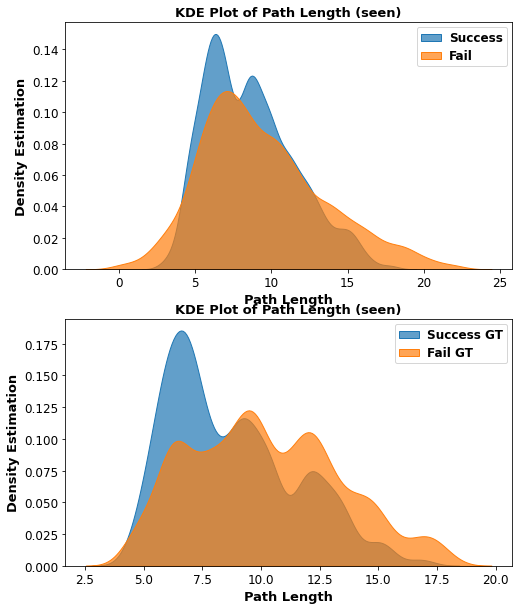

In [34]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(211)
sns.kdeplot(success_pl, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
sns.kdeplot(fail_pl, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
ax.set_xlabel("Path Length", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
ax.set_title("KDE Plot of Path Length (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success", "Fail"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
# plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')

ax = fig.add_subplot(212)
sns.kdeplot(success_pl_gt, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
sns.kdeplot(fail_pl_gt, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
ax.set_xlabel("Path Length", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
ax.set_title("KDE Plot of Path Length (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success GT", "Fail GT"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
plt.show()

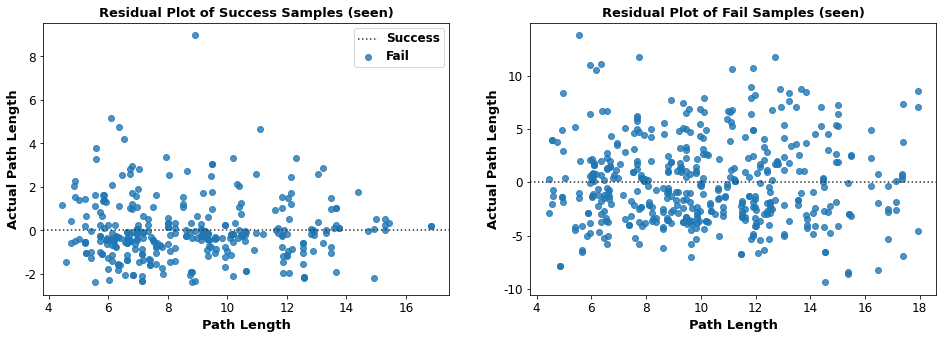

In [35]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)
sns.residplot(x=success_pl_gt, y=success_pl, label="Cyl=4", )
ax.set_xlabel("Path Length", fontsize=13, fontweight='bold')
ax.set_ylabel("Actual Path Length", fontsize=13, fontweight='bold')
ax.set_title("Residual Plot of Success Samples (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success", "Fail"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')


ax = fig.add_subplot(122)
sns.residplot(x=fail_pl_gt, y=fail_pl, label="Cyl=4", )
ax.set_xlabel("Path Length", fontsize=13, fontweight='bold')
ax.set_ylabel("Actual Path Length", fontsize=13, fontweight='bold')
ax.set_title("Residual Plot of Fail Samples (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
# plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')
plt.show()

### Path steps distribution

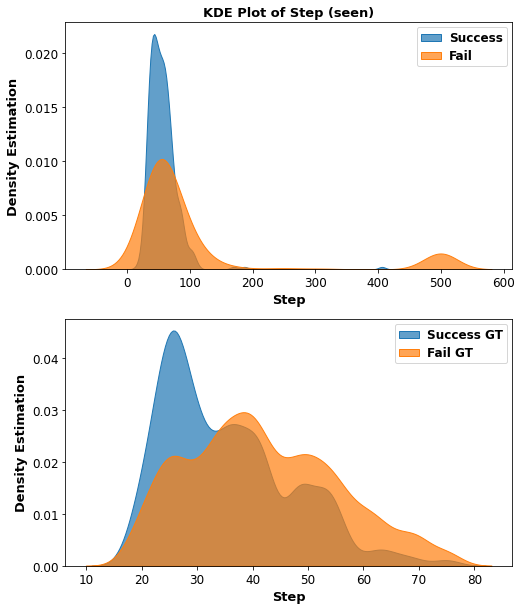

In [36]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(211)
sns.kdeplot(success_step, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
sns.kdeplot(fail_step, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
# c = [plt.cm.Spectral(i/1.0) for i in range(2)]
# sns.histplot({"Success": success_step, "Fail": fail_step}, ax=ax, kde=True, kde_kws={"gridsize": 100, "bw_method": 0.4}, line_kws={"linewidth":2}, zorder=1000)
ax.set_xlabel("Step", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
ax.set_title("KDE Plot of Step (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success", "Fail"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
# plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')


ax = fig.add_subplot(212)
sns.kdeplot(success_step_gt, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
sns.kdeplot(fail_step_gt, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
# c = [plt.cm.Spectral(i/1.0) for i in range(2)]
# sns.histplot({"Success": success_step_gt, "Fail": fail_step_gt}, ax=ax, kde=True, kde_kws={"gridsize": 100, "bw_method": 0.4}, line_kws={"linewidth":2}, zorder=1000)
ax.set_xlabel("Step", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
# ax.set_title("KDE Plot of Path Length (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success GT", "Fail GT"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
plt.show()

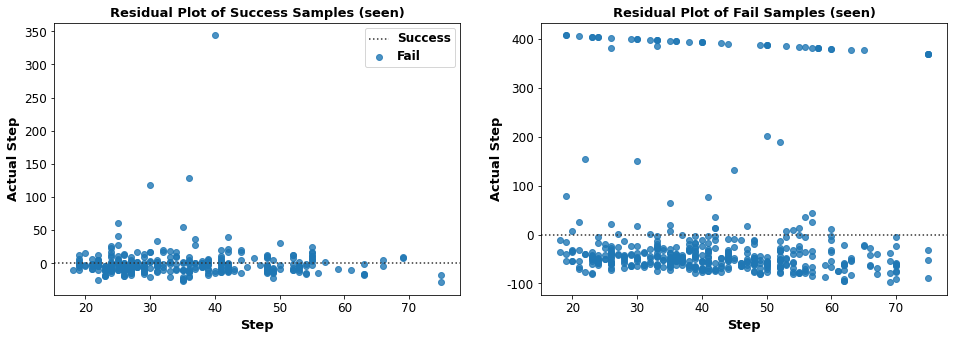

In [37]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)
sns.residplot(x=success_step_gt, y=success_step, label="Cyl=4", )
ax.set_xlabel("Step", fontsize=13, fontweight='bold')
ax.set_ylabel("Actual Step", fontsize=13, fontweight='bold')
ax.set_title("Residual Plot of Success Samples (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success", "Fail"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')


ax = fig.add_subplot(122)
sns.residplot(x=fail_step_gt, y=fail_step, label="Cyl=4", )
ax.set_xlabel("Step", fontsize=13, fontweight='bold')
ax.set_ylabel("Actual Step", fontsize=13, fontweight='bold')
ax.set_title("Residual Plot of Fail Samples (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
# plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')
plt.show()

# Unseen

In [38]:
success, fail, data, gt = read_data("val_unseen")
episodes = {v["episode_id"]:v for v in data["episodes"]}
gt = {int(k):v for k, v in gt.items()}

In [39]:
print("Success num: %d"%(len(success)))
print("Fail num: %d"%(len(fail)))

def extract_path_info(info_data):
    pl = []
    step = []
    pl_gt = []
    step_gt = []
    for k, v in info_data.items():
        pl.append(v["infos"]["path_length"])
        step.append(v["infos"]["steps_taken"])
        pl_gt.append(episodes[k]["info"]["geodesic_distance"])
        step_gt.append(gt[k]["forward_steps"])
    return pl,step,pl_gt,step_gt

success_pl, success_step, success_pl_gt, success_step_gt = extract_path_info(success)
fail_pl, fail_step, fail_pl_gt, fail_step_gt = extract_path_info(fail)

Success num: 600
Fail num: 1239


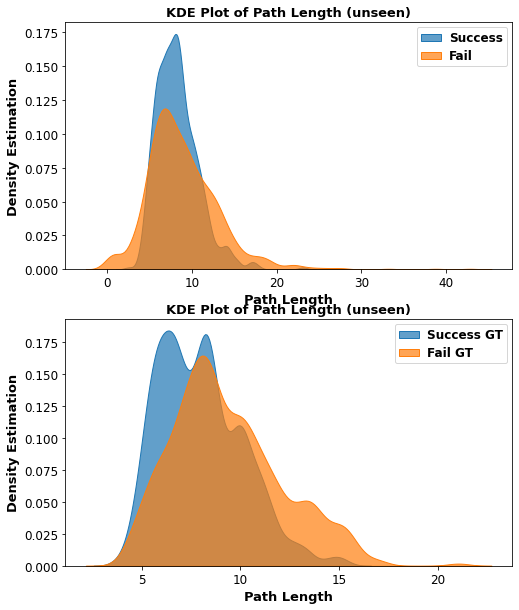

In [40]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(211)
sns.kdeplot(success_pl, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
sns.kdeplot(fail_pl, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
ax.set_xlabel("Path Length", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
ax.set_title("KDE Plot of Path Length (unseen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success", "Fail"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
# plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')

ax = fig.add_subplot(212)
sns.kdeplot(success_pl_gt, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
sns.kdeplot(fail_pl_gt, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
ax.set_xlabel("Path Length", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
ax.set_title("KDE Plot of Path Length (unseen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success GT", "Fail GT"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
plt.show()

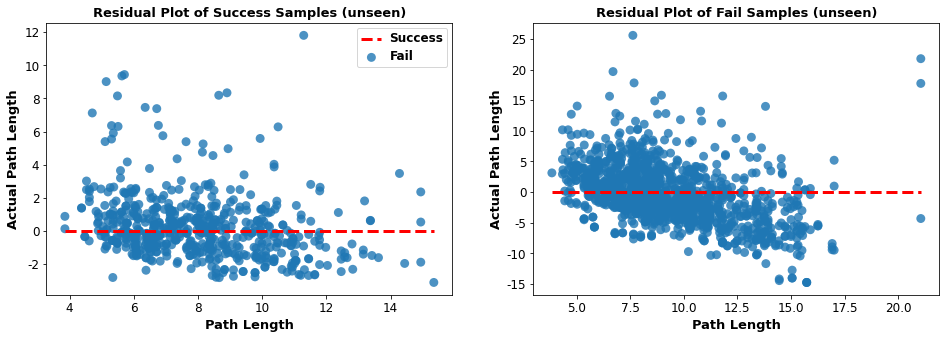

In [41]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)
# sns.residplot(x=success_pl_gt, y=success_pl, label="Cyl=4", )
ax.scatter(x=success_pl_gt, y=np.array(success_pl)-np.array(success_pl_gt), s=80, edgecolors='none', alpha=0.8)
ax.plot([np.min(success_pl_gt), np.max(success_pl_gt)],[0,0], c="r", linestyle="--", lw=3)
ax.set_xlabel("Path Length", fontsize=13, fontweight='bold')
ax.set_ylabel("Actual Path Length", fontsize=13, fontweight='bold')
ax.set_title("Residual Plot of Success Samples (unseen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success", "Fail"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')


ax = fig.add_subplot(122)
# sns.residplot(x=fail_pl_gt, y=fail_pl, label="Cyl=4", )
ax.scatter(x=fail_pl_gt, y=np.array(fail_pl)-np.array(fail_pl_gt), s=80, edgecolors='none', alpha=0.8)
ax.plot([np.min(fail_pl_gt), np.max(fail_pl_gt)],[0,0], c="r", linestyle="--", lw=3)
ax.set_xlabel("Path Length", fontsize=13, fontweight='bold')
ax.set_ylabel("Actual Path Length", fontsize=13, fontweight='bold')
ax.set_title("Residual Plot of Fail Samples (unseen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
# plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')
plt.show()

### Path steps distribution

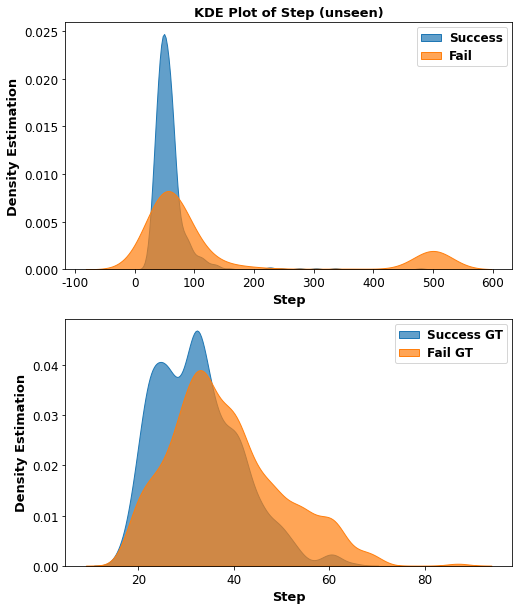

In [42]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(211)
sns.kdeplot(success_step, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
sns.kdeplot(fail_step, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
# c = [plt.cm.Spectral(i/1.0) for i in range(2)]
# sns.histplot({"Success": success_step, "Fail": fail_step}, ax=ax, kde=True, kde_kws={"gridsize": 100, "bw_method": 0.4}, line_kws={"linewidth":2}, zorder=1000)
ax.set_xlabel("Step", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
ax.set_title("KDE Plot of Step (unseen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success", "Fail"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
# plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')


ax = fig.add_subplot(212)
sns.kdeplot(success_step_gt, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
sns.kdeplot(fail_step_gt, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
# c = [plt.cm.Spectral(i/1.0) for i in range(2)]
# sns.histplot({"Success": success_step_gt, "Fail": fail_step_gt}, ax=ax, kde=True, kde_kws={"gridsize": 100, "bw_method": 0.4}, line_kws={"linewidth":2}, zorder=1000)
ax.set_xlabel("Step", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
# ax.set_title("KDE Plot of Path Length (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success GT", "Fail GT"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
plt.show()

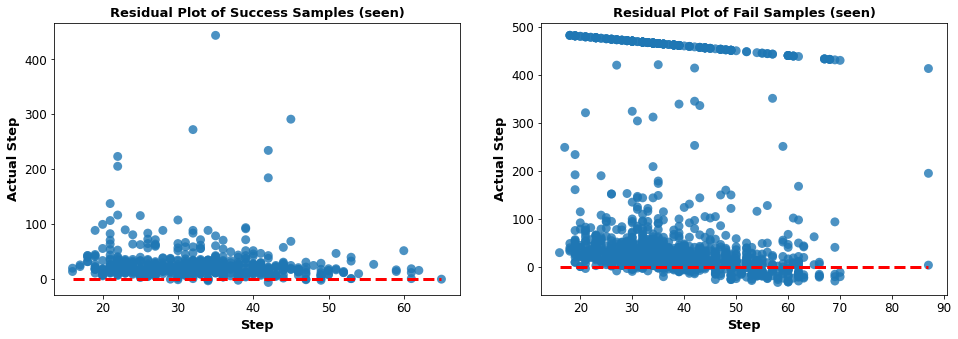

In [43]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)
# sns.residplot(x=success_step_gt, y=success_step, label="Cyl=4",  lowess=True, line_kws=dict(color="r"))
# sns.scatterplot(x=success_step_gt, y=np.array(success_step)-np.array(success_step_gt),s=80, edgecolors='none', alpha=0.7)
ax.scatter(x=success_step_gt, y=np.array(success_step)-np.array(success_step_gt), s=80, edgecolors='none', alpha=0.8)
ax.plot([np.min(success_step_gt), np.max(success_step_gt)],[0,0], c="r", linestyle="--", lw=3)
ax.set_xlabel("Step", fontsize=13, fontweight='bold')
ax.set_ylabel("Actual Step", fontsize=13, fontweight='bold')
ax.set_title("Residual Plot of Success Samples (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )


ax = fig.add_subplot(122)
# sns.residplot(x=fail_step_gt, y=fail_step, label="Cyl=4", order=1, lowess=True, line_kws=dict(color="r"))
# sns.scatterplot(x=fail_step_gt, y=np.array(fail_step)-np.array(fail_step_gt))
ax.scatter(x=fail_step_gt, y=np.array(fail_step)-np.array(fail_step_gt), s=80, edgecolors='none', alpha=0.8)
ax.plot([np.min(fail_step_gt), np.max(fail_step_gt)],[0,0], c="r", linestyle="--", lw=3)
ax.set_xlabel("Step", fontsize=13, fontweight='bold')
ax.set_ylabel("Actual Step", fontsize=13, fontweight='bold')
ax.set_title("Residual Plot of Fail Samples (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
# plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')
plt.show()

## Unseen fail samples, step analysis

In [44]:
avg_step = np.mean(success_step_gt+fail_step_gt)
print("Average steps: ", avg_step)
avg_pl = np.mean(success_pl_gt+fail_pl_gt)
print("Average length: ", avg_pl)

action_final = load_action("/home/ubuntu/MLA/action_%s.pkl"%("val_unseen"))

Average steps:  36.30668841761827
Average length:  8.899339109610578


In [45]:
# 步数小于或远超真值的比例
abnormal_id = []
for i,(k,v) in enumerate(fail.items()):
    if fail_step[i]-fail_step_gt[i]>fail_step_gt[i] or fail_step[i]-fail_step_gt[i]<-fail_step_gt[i]/4:
        # print(v)
        abnormal_id.append(k)
print("Propotion (abnormal steps / total fails)", len(abnormal_id)/len(fail))

Propotion (abnormal steps / total fails) 0.4745762711864407


In [46]:
# 到达上限的比例
exceed = []
for v in fail.keys():
    action = action_final[v]
    if len(action)==500:
        exceed.append(v)
print("Propotion (exceed maximum / total fails)", len(exceed)/len(fail))

Propotion (exceed maximum / total fails) 0.15415657788539144


In [47]:
# 异常模式的比例
# 一次前进是0.25米，一次转向是15度
# 若前进100次则为25米，远超平均路径长度；若连续转向100次，则转了1500度，远超一圈
def stringfy(a):
    return " ".join([str(v) for v in a])
def find_recurrent(s, k, threshold=9):
    i = 0
    if i+k>=len(s):
        return False, None
    p = s[i:i+k]
    c = 0
    while i+k<len(s):
        if (s[i:i+k]==p).all():
            c += 1
        else:
            p = s[i:i+k]
            c = 1
        if c>=threshold:
            return True, p
        i += k
    return False, None
def is_recurrent_pattern(s, lmin=2, lmax=5):
    for k in range(lmin,lmax+1,1):
        res, pattern = find_recurrent(s, k, threshold=int(100/k))
        if res:
            return res, pattern
    return False, None
ab_pattern = []
for v in exceed:
    # s = stringfy(action_final[v])
    res, pattern = is_recurrent_pattern(action_final[v])
    # print(s)
    if res:
        ab_pattern.append((v, pattern))
print("Propotion (abnormal pattern / total fails)", len(ab_pattern)/len(fail))
print("Propotion (abnormal pattern / exceed)", len(ab_pattern)/len(exceed))

Propotion (abnormal pattern / total fails) 0.12832929782082325
Propotion (abnormal pattern / exceed) 0.8324607329842932


In [48]:
unique_patterns = [tuple(v[1]) for v in ab_pattern]
unique_patterns = set(unique_patterns)
print(unique_patterns)

{(1, 1, 2, 1, 3), (2, 3, 3, 2), (1, 3, 1, 1, 2), (3, 1, 2, 3, 2), (1, 2, 1, 3), (1, 1, 3, 2), (2, 3, 1), (3, 3), (2, 2), (3, 1, 2), (1, 1), (3, 2), (1, 2, 1, 3, 1), (2, 3), (2, 1, 3, 1), (3, 1, 2, 1), (2, 1, 3, 1, 1), (1, 3, 1, 2), (2, 1, 3), (3, 1, 1, 2, 1), (3, 2, 1, 1)}


In [49]:
# 过少步数
short = []
for i,(k,v) in enumerate(fail.items()):
    if fail_step[i]-fail_step_gt[i]<-fail_step_gt[i]/4:
        # print(action_final[k])
        short.append(k)
print("Portion (too short / total fails)", len(short)/len(fail))

Portion (too short / total fails) 0.053268765133171914


1. 过早stop
2. 重复多次的异常模式

In [71]:
check_list = []
all_list = [(v[0], tuple(v[1])) for v in ab_pattern]
patterns = unique_patterns.copy()
for v in all_list:
    if v[1] in patterns:
        patterns.remove(v[1])
        check_list.append((v[0],v[1]))
for v in check_list:
    print("Episode %d:\treapeat pattern %s"%(v[0],repr(v[1])), end="\n\n")

In [64]:
patterns

set()

Episode 6:	reapeat pattern (2, 3)

Episode 57:	reapeat pattern (3, 2)

Episode 149:	reapeat pattern (1, 3, 1, 1, 2)

Episode 117:	reapeat pattern (2, 1, 3, 1)

Episode 434:	reapeat pattern (2, 1, 3)

Episode 435:	reapeat pattern (1, 2, 1, 3)

Episode 752:	reapeat pattern (1, 1, 2, 1, 3)

Episode 753:	reapeat pattern (3, 1, 1, 2, 1)

Episode 794:	reapeat pattern (3, 3)

Episode 1115:	reapeat pattern (1, 1)

Episode 1284:	reapeat pattern (3, 1, 2, 1)

Episode 389:	reapeat pattern (3, 2, 1, 1)

Episode 486:	reapeat pattern (2, 3, 3, 2)

Episode 552:	reapeat pattern (1, 3, 1, 2)

Episode 852:	reapeat pattern (2, 1, 3, 1, 1)

Episode 941:	reapeat pattern (3, 1, 2, 3, 2)

Episode 1304:	reapeat pattern (1, 1, 3, 2)

Episode 1512:	reapeat pattern (1, 2, 1, 3, 1)

Episode 1687:	reapeat pattern (3, 1, 2)

Episode 290:	reapeat pattern (2, 3, 1)

Episode 1507:	reapeat pattern (2, 2)



In [74]:
exce = set([v[0] for v in ab_pattern])
all_fail = set(fail.keys())
rest = all_fail - exce
check_list = random.sample(rest,10)
for v in sorted(check_list):
    print("Episode %d"%(v), end="\n\n")

Episode 251

Episode 499

Episode 547

Episode 843

Episode 1018

Episode 1426

Episode 1459

Episode 1582

Episode 1632

Episode 1705

